# Simple Stock Price Prediction

A simplified stock prediction model using:
- Basic data collection from Yahoo Finance
- Essential technical indicators
- Simple LSTM model with PyTorch
- Future price predictions

In [3]:
# # Install required packages
# %pip install torch pandas matplotlib yfinance scikit-learn

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached frozendict-2.4.6-py313-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.2-py3-none-any.whl
  Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   -------------------------------- ------- 1.3/1.6 MB 18.5 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.9 MB/s eta 0:00:00
Using cached frozendict-2.4.6-py313-none-any.whl (16 kB)
Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl (176 kB)
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15703 sha256=967d14d7c17f8ce4bec3a34ca55fe3452724


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Using device: cuda


In [5]:
# Get stock data
SYMBOL = "RELIANCE.NS"  # NSE stock symbol
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

print(f"Fetching data for {SYMBOL}")
stock_data = yf.download(SYMBOL, start=START_DATE, end=END_DATE)

if not stock_data.empty:
    print(f"Data shape: {stock_data.shape}")
    print(f"Date range: {stock_data.index.min()} to {stock_data.index.max()}")
    print("\nFirst few rows:")
    print(stock_data.head())
else:
    print("Failed to fetch data. Please check the symbol.")

Fetching data for RELIANCE.NS


[*********************100%***********************]  1 of 1 completed

Data shape: (1237, 5)
Date range: 2020-01-01 00:00:00 to 2024-12-30 00:00:00

First few rows:
Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2020-01-01  675.324219  683.152914  673.490123  679.081997    14004468
2020-01-02  686.821228  689.348791  676.397899  676.397899    17710316
2020-01-03  687.648865  689.661956  681.318790  685.792313    20984698
2020-01-06  671.700684  683.510767  670.134933  679.976719    24519177
2020-01-07  682.034485  686.463273  677.068828  679.529260    16683622


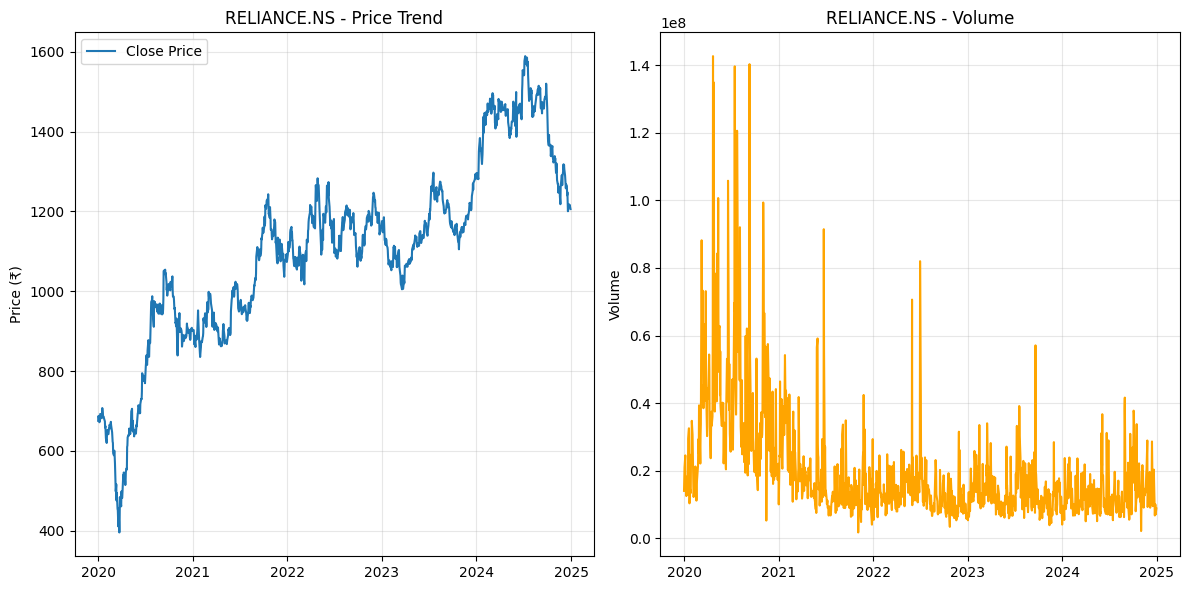


Basic Statistics:
Ticker  RELIANCE.NS
count   1237.000000
mean    1100.072183
std      231.615739
min      395.482483
25%      955.388794
50%     1120.699097
75%     1225.107544
max     1589.138184


In [6]:
# Simple data visualization
if stock_data is not None and not stock_data.empty:
    plt.figure(figsize=(12, 6))
    
    # Plot closing price
    plt.subplot(1, 2, 1)
    plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
    plt.title(f'{SYMBOL} - Price Trend')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot volume
    plt.subplot(1, 2, 2)
    plt.plot(stock_data.index, stock_data['Volume'], color='orange')
    plt.title(f'{SYMBOL} - Volume')
    plt.ylabel('Volume')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBasic Statistics:")
    print(stock_data['Close'].describe())

In [7]:
# Create simple technical indicators
def create_features(df):
    data = df.copy()
    
    # Moving averages
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    
    # RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # Price change
    data['Price_Change'] = data['Close'].pct_change()
    
    return data

# Create features
if stock_data is not None and not stock_data.empty:
    enhanced_data = create_features(stock_data)
    
    # Drop NaN values
    enhanced_data = enhanced_data.dropna()
    
    print(f"Enhanced data shape: {enhanced_data.shape}")
    print(f"Features: {list(enhanced_data.columns)}")
    print("\nSample data:")
    print(enhanced_data.tail())

Enhanced data shape: (1218, 9)
Features: [('Close', 'RELIANCE.NS'), ('High', 'RELIANCE.NS'), ('Low', 'RELIANCE.NS'), ('Open', 'RELIANCE.NS'), ('Volume', 'RELIANCE.NS'), ('MA_5', ''), ('MA_20', ''), ('RSI', ''), ('Price_Change', '')]

Sample data:
Price             Close         High          Low         Open      Volume  \
Ticker      RELIANCE.NS  RELIANCE.NS  RELIANCE.NS  RELIANCE.NS RELIANCE.NS   
Date                                                                         
2024-12-23  1217.437744  1222.318155  1208.373847  1210.166735    10052824   
2024-12-24  1217.885864  1228.642950  1216.142826  1217.437703     6734917   
2024-12-26  1211.710571  1222.816119  1209.419672  1219.379892    10016178   
2024-12-27  1216.192749  1223.015476  1212.158811  1213.453688     7000397   
2024-12-30  1205.883789  1218.334064  1203.294156  1211.561187     8818766   

Price              MA_5        MA_20        RSI Price_Change  
Ticker                                                        
Da

In [8]:
# Prepare data for training
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=60):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length, 0]  # Close price
        return torch.FloatTensor(x), torch.FloatTensor([y])

def prepare_data(data, sequence_length=60, train_split=0.8):
    # Select features
    feature_columns = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_20', 'RSI', 'Price_Change']
    features = data[feature_columns].values
    
    # Normalize
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Split data
    train_size = int(len(scaled_features) * train_split)
    train_data = scaled_features[:train_size]
    test_data = scaled_features[train_size:]
    
    # Create datasets
    train_dataset = StockDataset(train_data, sequence_length)
    test_dataset = StockDataset(test_data, sequence_length)
    
    return train_dataset, test_dataset, scaler, feature_columns

# Prepare data
if 'enhanced_data' in locals():
    SEQUENCE_LENGTH = 60
    BATCH_SIZE = 32
    
    train_dataset, test_dataset, scaler, feature_columns = prepare_data(enhanced_data, SEQUENCE_LENGTH)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")
    print(f"Features: {len(feature_columns)}")

Training samples: 914
Testing samples: 184
Features: 9


In [9]:
# Simple LSTM Model
class SimpleStockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1):
        super(SimpleStockPredictor, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Take last output
        return output

# Initialize model
if 'feature_columns' in locals():
    INPUT_SIZE = len(feature_columns)
    model = SimpleStockPredictor(INPUT_SIZE).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("Simple model initialized:")
    print(model)
    print(f"Input size: {INPUT_SIZE}")
    print(f"Device: {device}")

Simple model initialized:
SimpleStockPredictor(
  (lstm): LSTM(9, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Input size: 9
Device: cuda


Training the model...
Epoch [10/50] Train Loss: 0.000483, Test Loss: 0.001392
Epoch [10/50] Train Loss: 0.000483, Test Loss: 0.001392
Epoch [20/50] Train Loss: 0.000429, Test Loss: 0.001210
Epoch [20/50] Train Loss: 0.000429, Test Loss: 0.001210
Epoch [30/50] Train Loss: 0.000428, Test Loss: 0.001871
Epoch [30/50] Train Loss: 0.000428, Test Loss: 0.001871
Epoch [40/50] Train Loss: 0.000334, Test Loss: 0.000748
Epoch [40/50] Train Loss: 0.000334, Test Loss: 0.000748
Epoch [50/50] Train Loss: 0.000274, Test Loss: 0.000569
Epoch [50/50] Train Loss: 0.000274, Test Loss: 0.000569


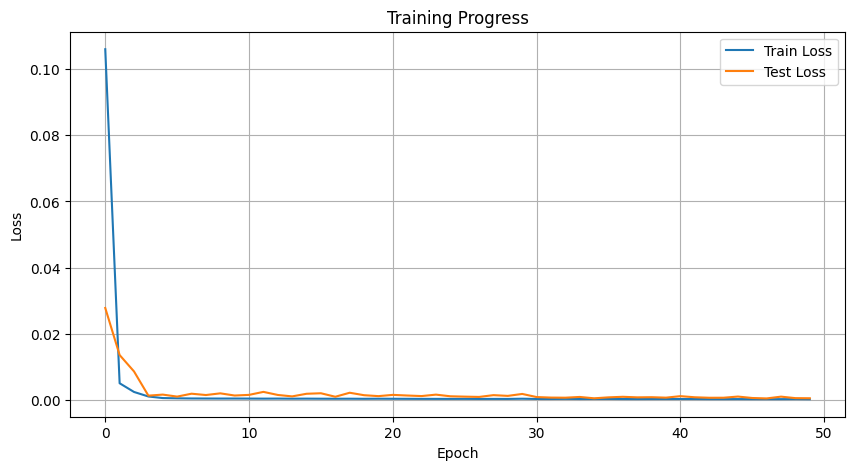

Training completed!


In [10]:
# Simple training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')
    
    return train_losses, test_losses

# Train the model
if 'model' in locals() and 'train_loader' in locals():
    print("Training the model...")
    train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer)
    
    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("Training completed!")

Model Evaluation:
RMSE: 28.87
Mean Actual Price: ₹1415.92


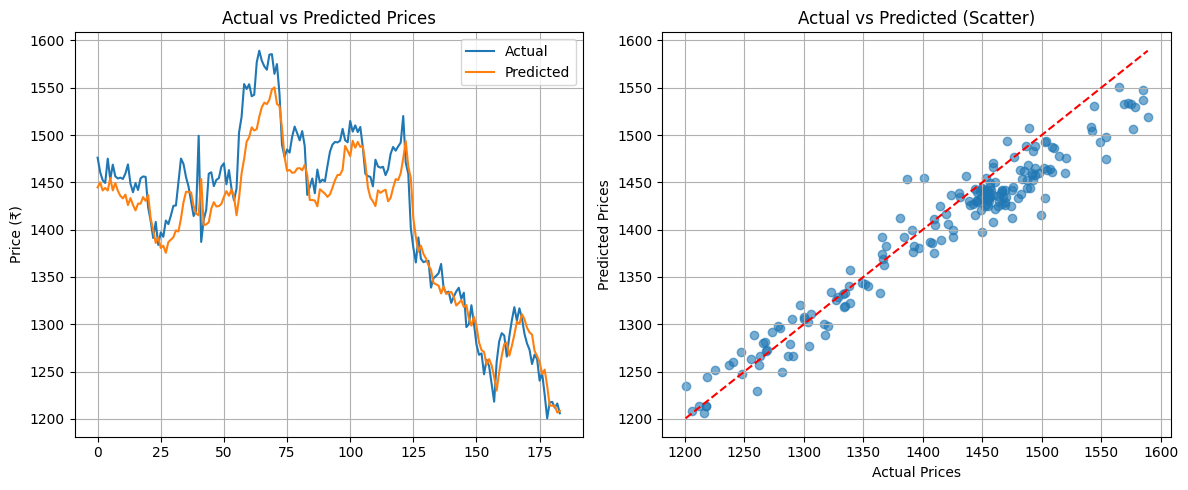

In [11]:
# Model evaluation
def evaluate_model(model, test_loader, scaler):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    # Convert back to actual prices
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverse transform
    dummy_features = np.zeros((len(predictions), scaler.n_features_in_))
    dummy_features[:, 0] = predictions.flatten()
    predictions_scaled = scaler.inverse_transform(dummy_features)[:, 0]
    
    dummy_features[:, 0] = actuals.flatten()
    actuals_scaled = scaler.inverse_transform(dummy_features)[:, 0]
    
    return predictions_scaled, actuals_scaled

# Evaluate model
if 'model' in locals() and 'test_loader' in locals():
    predictions, actuals = evaluate_model(model, test_loader, scaler)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    
    print(f"Model Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"Mean Actual Price: ₹{np.mean(actuals):.2f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Prices')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(actuals, predictions, alpha=0.6)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs Predicted (Scatter)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

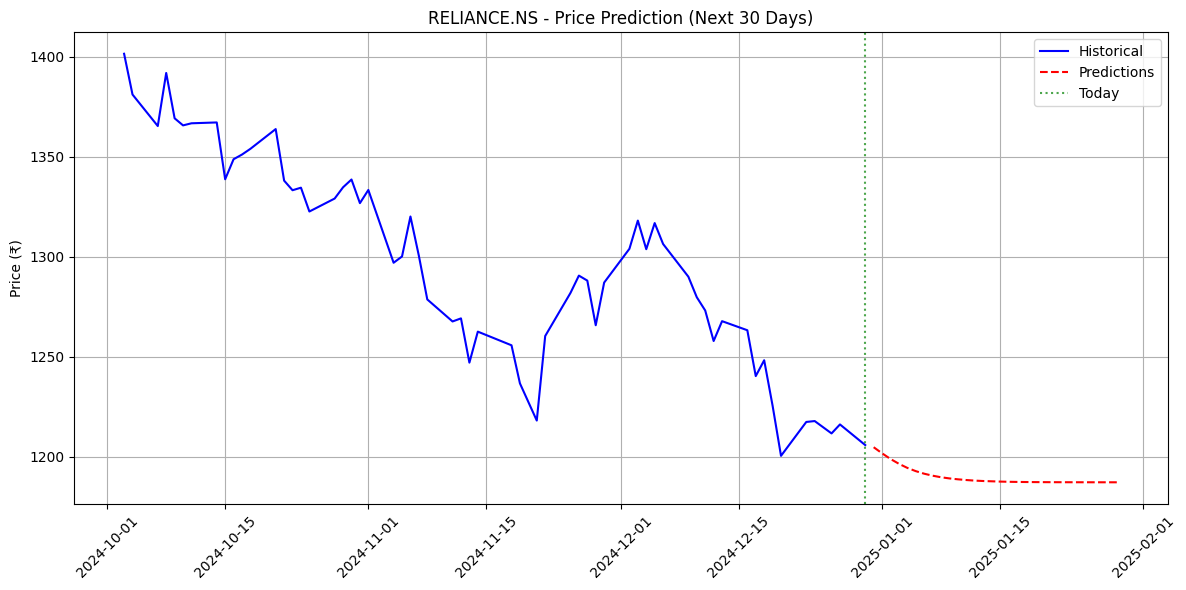


Current Price: ₹1205.88
Predicted Price (1 day): ₹1204.81
Predicted Price (30 days): ₹1187.29
30-day predicted return: -1.54%


In [13]:
# Future price prediction
def predict_future(model, last_sequence, scaler, num_days=30):
    model.eval()
    predictions = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(num_days):
            input_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
            prediction = model(input_tensor)
            predicted_price = prediction.cpu().numpy()[0, 0]
            predictions.append(predicted_price)
            
            # Update sequence
            new_row = current_sequence[-1].copy()
            new_row[0] = predicted_price
            current_sequence = np.vstack([current_sequence[1:], new_row])
    
    # Convert back to actual prices
    predictions = np.array(predictions).reshape(-1, 1)
    dummy_features = np.zeros((len(predictions), scaler.n_features_in_))
    dummy_features[:, 0] = predictions.flatten()
    predictions_scaled = scaler.inverse_transform(dummy_features)[:, 0]
    
    return predictions_scaled

# Make future predictions
if 'model' in locals() and 'enhanced_data' in locals():
    # Get last sequence
    last_data = enhanced_data[feature_columns].iloc[-SEQUENCE_LENGTH:].values
    last_sequence_scaled = scaler.transform(last_data)
    
    # Predict next 30 days
    future_predictions = predict_future(model, last_sequence_scaled, scaler, 30)
    
    # Create future dates
    last_date = enhanced_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
    
    # Plot predictions
    plt.figure(figsize=(12, 6))
    
    # Historical data (last 60 days)
    recent_data = enhanced_data['Close'].iloc[-60:]
    plt.plot(recent_data.index, recent_data.values, label='Historical', color='blue')
    
    # Future predictions
    plt.plot(future_dates, future_predictions, label='Predictions', color='red', linestyle='--')
    
    plt.axvline(x=last_date, color='green', linestyle=':', alpha=0.7, label='Today')
    plt.title(f'{SYMBOL} - Price Prediction (Next 30 Days)')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display predictions
    current_price = recent_data.iloc[-1]
    current_price_value = current_price.iloc[0] if hasattr(current_price, "iloc") else float(current_price)
    print(f"\nCurrent Price: ₹{current_price_value:.2f}")
    print(f"Predicted Price (1 day): ₹{future_predictions[0]:.2f}")
    print(f"Predicted Price (30 days): ₹{future_predictions[29]:.2f}")
    
    predicted_return = (future_predictions[29] - current_price_value) / current_price_value * 100
    print(f"30-day predicted return: {predicted_return:.2f}%")

## Summary

This simplified stock prediction notebook includes:

✅ **Simple Data Collection**: Yahoo Finance for reliable data
✅ **Basic Features**: Only essential technical indicators (MA, RSI, Price Change)
✅ **Simple LSTM**: Single-layer LSTM model
✅ **Clean Training**: Straightforward training loop
✅ **Easy Predictions**: 30-day future price forecasts

**Usage**: 
- Change `SYMBOL` to predict different stocks
- Adjust parameters as needed
- Run all cells in sequence

**Note**: This is for educational purposes only. Always do your own research before investing.